In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


### This notebook seeks to recreate the algorithm used in calculateDeltaTConstants.C from Jason in python, hopefully in a way that is a little more readable.

We will use the method detailed in note 16841 to construct a matrix of deltaT clusters for adjacent crystals in each calorimeter, and then use SciPy singular value decomposition in order to arrive at the xtal-to-xtal timing alignment constants for each calorimeter.

* Matrix = 1/-1 depending on the calorimeters being subtracted

* RHS = vector of deltaT values (mean from gaussian fit)

Both of these should be divided by the error in the mean from the gaussian fit

---

In [2]:
#open the file containing the hitDeltaTXXX histograms. These are produced as an output from:
#    https://cdcvs.fnal.gov/redmine/projects/gm2calo/repository/entry/analyses/NeighboringCrystalsTimeExtraction_module.cc?rev=run2Templates
f = r.TFile("./data/gm2deltaTAnalysis_full.root")
f.cd("neighboringCrystalsDeltaT")
f.ls()

TFile**		./data/gm2deltaTAnalysis_full.root	
 TFile*		./data/gm2deltaTAnalysis_full.root	
  TDirectoryFile*		neighboringCrystalsDeltaT	neighboringCrystalsDeltaT (NeighboringCrystalsTimeExtraction) folder
   KEY: TH3D	hitDeltaT0;1	calo 0 delta t
   KEY: TH3D	hitDeltaT1;1	calo 1 delta t
   KEY: TH3D	hitDeltaT2;1	calo 2 delta t
   KEY: TH3D	hitDeltaT3;1	calo 3 delta t
   KEY: TH3D	hitDeltaT4;1	calo 4 delta t
   KEY: TH3D	hitDeltaT5;1	calo 5 delta t
   KEY: TH3D	hitDeltaT6;1	calo 6 delta t
   KEY: TH3D	hitDeltaT7;1	calo 7 delta t
   KEY: TH3D	hitDeltaT8;1	calo 8 delta t
   KEY: TH3D	hitDeltaT9;1	calo 9 delta t
   KEY: TH3D	hitDeltaT10;1	calo 10 delta t
   KEY: TH3D	hitDeltaT11;1	calo 11 delta t
   KEY: TH3D	hitDeltaT12;1	calo 12 delta t
   KEY: TH3D	hitDeltaT13;1	calo 13 delta t
   KEY: TH3D	hitDeltaT14;1	calo 14 delta t
   KEY: TH3D	hitDeltaT15;1	calo 15 delta t
   KEY: TH3D	hitDeltaT16;1	calo 16 delta t
   KEY: TH3D	hitDeltaT17;1	calo 17 delta t
   KEY: TH3D	hitDeltaT18;1	calo 18 delta t

In [3]:
calo = 2
h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo)).Clone("h_"+str(calo))
h.SetDirectory(0)

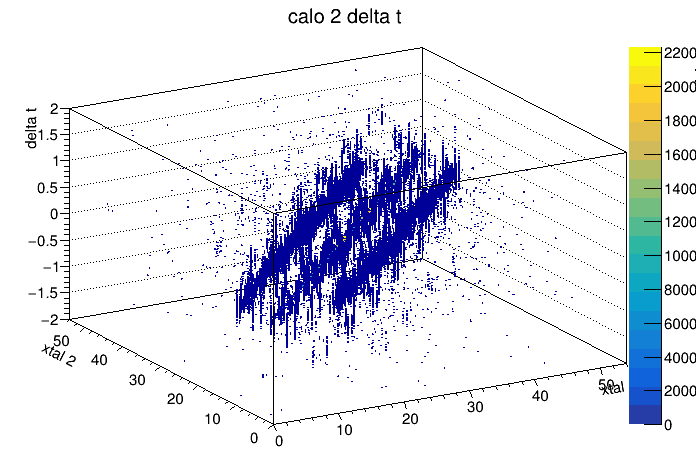

In [4]:
c = r.TCanvas()
h.Draw("lego2z")
c.Draw()

---

### Lets calculate the values for the matrices in each calorimeter

In [5]:
#useful helper functions

#converts xtal number into x/y position in calorimeter and vice versa
def xtalNumToPosition(x, y = np.nan):
    #if we are given two values, convert xtal position in calo to xtal number
    if(y is not np.nan):
        return x + y*9
    else:
        return (x % 9, int(np.floor(x/9)))

#returns the neighboring crystals in a grid in the form of an iterator
def ReturnNeighbors_NoDiagonal(x, y):
    for i in range(x - 1, x + 2):
        for j in range(y - 1, y + 2):
            if (((i, j) != (x, y)) and i < 9 and j < 6 and i > -1 and j > -1):
                #print(np.abs(i-x) + np.abs(j-y), i, j )
                if(np.abs(i-x) + np.abs(j-y) < 2):
                    yield (int(i), int(j))

In [6]:
#this crystals deltaT value will be set to 0 as a reference in all calorimeters
xtalToFix = 0

In [7]:
#xtals which are dead or should otherwise just be set to 0
skipXtals = [
    #(15,2)
]

Starting calo 1
Starting calo 2
Starting calo 3
Starting calo 4
Starting calo 5
Starting calo 6
Starting calo 7
Starting calo 8
Starting calo 9
Starting calo 10
Starting calo 11
Starting calo 12
Starting calo 13
Starting calo 14
Starting calo 15
     Empty Fit Data in xtal pair 1 / 2
     Empty Fit Data in xtal pair 2 / 1
     Empty Fit Data in xtal pair 2 / 11
     Empty Fit Data in xtal pair 2 / 3
     Empty Fit Data in xtal pair 3 / 2
     Empty Fit Data in xtal pair 11 / 2
Starting calo 16
Starting calo 17
Starting calo 18
Starting calo 19
Starting calo 20
Starting calo 21
Starting calo 22
Starting calo 23
Starting calo 24


Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 


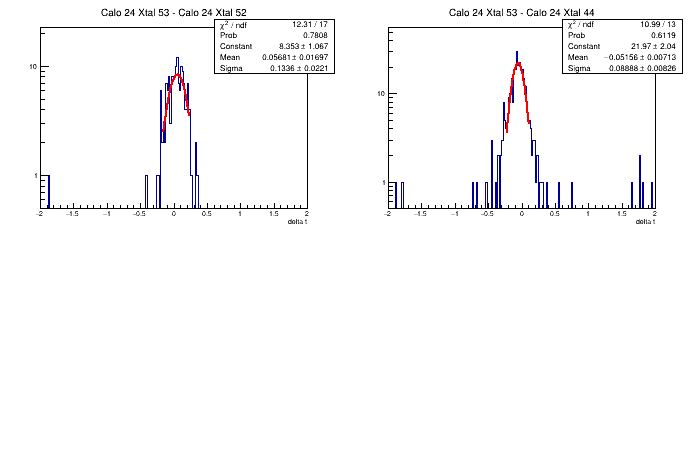

In [42]:
shape = (1,54) #shape of each row in the calorimeter matrix
caloMatrices = []

allChiSquareNDF = []
allN = []

allMeans = []
allCalos = []
allXtals = []

#for calo in [13,14]:
for calo in range(1,25):
    print("Starting calo", calo)
    
    #get the histogram for this calo
    h = f.Get("neighboringCrystalsDeltaT/hitDeltaT"+str(calo-1)).Clone("h_"+str(calo))
    h.SetDirectory(0)
    
    #create a matrix in which to store the xtal values and the deltaT value
    matrix = np.zeros(shape, dtype=float)
    rhs = np.zeros((1,1),dtype=float)
    #print(matrix)
    #print(rhs)

    takenPairs = [] #use this to avoid processing pairs like (1,0)/(0,1) twice. Just saves time.
    for xtal in range(54):
        adjXtals = [] #holds histograms from xtals adjacent to xtal
        c = r.TCanvas()
        c.Divide(2,2)
        i = 0
        #loop over the crystals which neighbor the reference xtal
        for x2, y2 in ReturnNeighbors_NoDiagonal(xtalNumToPosition(xtal)[0],xtalNumToPosition(xtal)[1]):
            c.cd(i+1)
            xtal2 = xtalNumToPosition(x2,y2) #convert positions in the caloriemter into an xtal number
            
            #get and draw the deltaT histogram for this pair of crystals
            bin_xtal = h.GetXaxis().FindBin(xtal)
            bin_xtal2 = h.GetYaxis().FindBin(xtal2)
            h.GetXaxis().SetRange(bin_xtal, bin_xtal)
            h.GetYaxis().SetRange(bin_xtal2, bin_xtal2)
            hi = h.Project3D("z").Clone("h_"+str(xtal2))
            hi.SetTitle("Calo "+str(calo)+" Xtal "+str(xtal)+" - "+"Calo "+str(calo)+" Xtal "+str(xtal2))
            allN.append(hi.GetEntries())
            adjXtals.append(hi.Clone("h_"+str(xtal2)))
            adjXtals[i].Draw()
            r.gPad.SetLogy()

            #calculate the mean and weight of the deltaT histogram
            mean = hi.GetMean() #initial values, later changed to values from gaussian fit
            weight = 1
            
            #fit the deltaT histogram using a gaussian. We can play with the range here to ensure good fits.
            func = r.TF1("func","gaus",-10,10)
            func.SetParameters(1,mean,0.3)
            for ieunerin in range(2):
                adjXtals[i].Fit(func,"REMBQ","")#, mean-0.5, mean+0.5)
            sigma = func.GetParameter(2)
            mean = func.GetParameter(1)
            func.SetParLimits(1,mean-0.5, mean+0.5)
            adjXtals[i].Fit(func,"REMBQ","", mean-1.5*sigma, mean+1.5*sigma)
            
            #from the fit, calculate new values of the mean/weight
            try: #if the fit worked (i.e. the histogram was not empty) this should succeed
                allChiSquareNDF.append( func.GetChisquare() / func.GetNDF() )
                if(func.GetChisquare() / func.GetNDF() < 10):
                    #mean = hi.GetMean()
                    #weight = hi.GetRMS()
                    mean = func.GetParameter(1)
                    #weight = func.GetParameter(2)
                    weight = func.GetParError(1)
                else:
                    print("     Bad xtal", xtal2)
            except:
                allChiSquareNDF.append(0)
                print("     Empty Fit Data in xtal pair", xtal, "/", xtal2)
                
            #save some values for verification plots later
            allMeans.append((mean,weight))
            allXtals.append((calo-1)*54 + xtal)
            allCalos.append(calo)
            #print(mean,stdev)

            #create a new row in each of the matrices and set the values accordingly
            newMatrixRow = [[0 for i in range(54)]]
            if((xtal == xtalToFix) or ((calo,xtal) in skipXtals)):
                #print(calo,xtal)
                #this being set to a very large number effectively fixes the constant for this xtal at 0
                newMatrixRow[0][xtal] = +10000000
                newRHS = [[0]]
            else:
                newMatrixRow[0][xtal] = +1/weight
                newRHS = [[mean/weight]]
                newMatrixRow[0][xtal2] = -1/weight 
            #print(newMatrixRow)

            #append these rows to the existing matrices and update the pairs which have been processed
            if( (xtal, xtal2) not in takenPairs and (xtal2, xtal) not in takenPairs ):
                matrix = np.append(matrix, newMatrixRow, 0)
                rhs = np.append(rhs, newRHS, 0)
                if(xtal != xtalToFix):
                    takenPairs.append((xtal,xtal2))
                
            i+=1

        #hi.Draw()
        c.Draw()
        #c.Print("./images/deltat/DeltaT_Calo_"+str(calo).zfill(2)+"_Xtal_"+str(xtal).zfill(2)+"_Xtal2_"+str(xtal2).zfill(2)+".png")

    #delete first placeholder row of all zeros from the matrices
    matrix = np.delete(matrix, 0, 0)
    rhs = np.delete(rhs, 0, 0)
    
    #add to running list of matrices for all calos
    caloMatrices.append((calo, matrix, rhs))

---

### Some verification plots for the fits

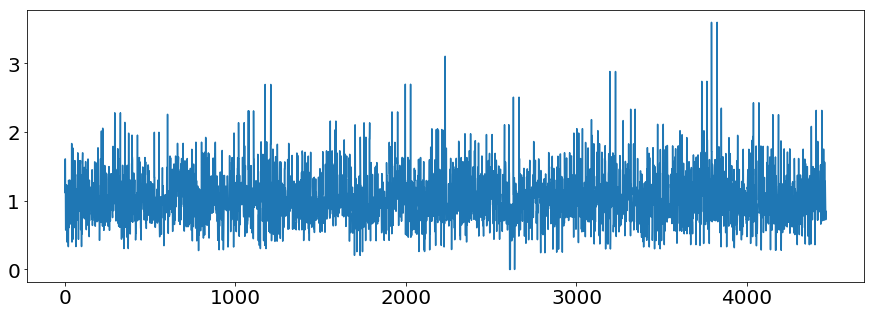

In [43]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(allChiSquareNDF)
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.show()

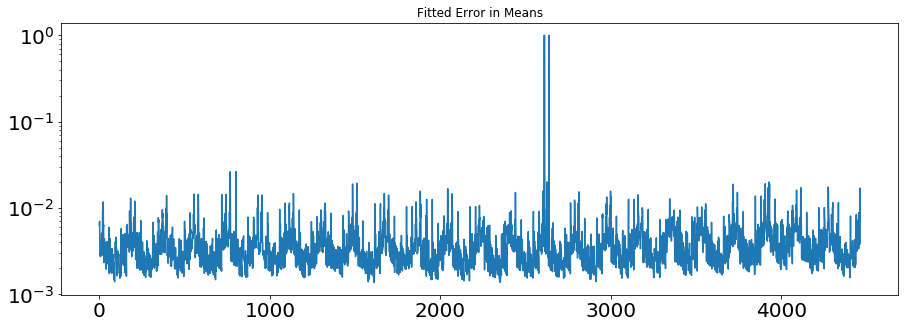

In [44]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.plot([y for x,y in allMeans])
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Error in Means")
plt.yscale("log")
plt.show()

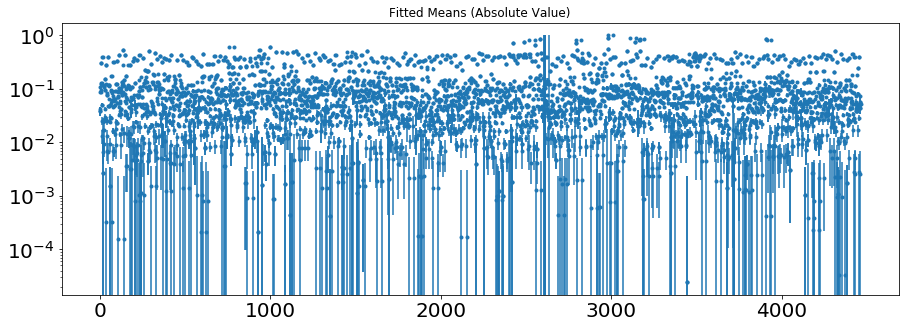

In [45]:
means, stdevs = zip(*allMeans)

fig,ax = plt.subplots(figsize=(15,5))

plt.errorbar([x for x in range(len(means))], np.abs(means), yerr=stdevs, fmt=".")
#plt.plot([0,len(allChiSquareNDF)], [10,10])
plt.title("Fitted Means (Absolute Value)")
plt.yscale("log")
plt.show()

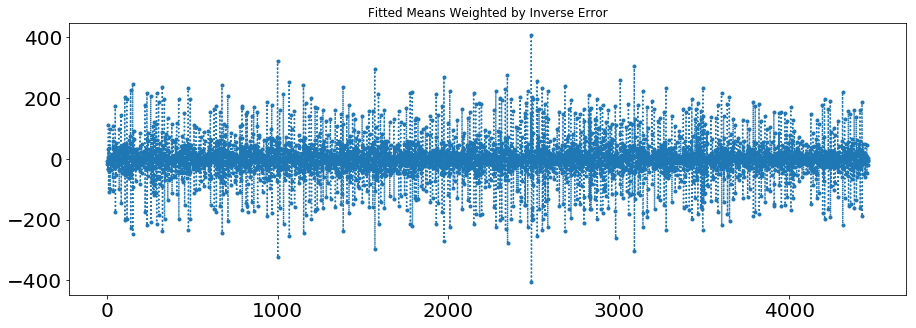

In [46]:
fig,ax = plt.subplots(figsize=(15,5))

plt.errorbar([x for x in range(len(means))], [x/y for x,y in allMeans], yerr=0, fmt=".:")
plt.title("Fitted Means Weighted by Inverse Error")
#plt.yscale("log")
plt.show()

/home/jlab/anaconda3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


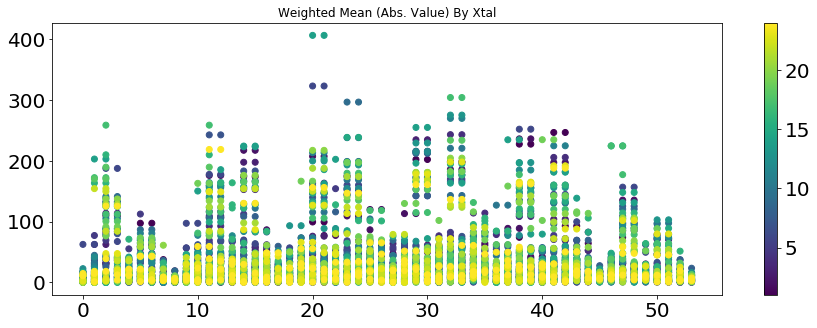

In [47]:
fig,ax = plt.subplots(figsize=(15,5))
plt.scatter([x%54 for x in allXtals], [np.abs(x/y) for x,y in allMeans], 
            c=allCalos, 
            vmin=1,
            vmax=24
           )
plt.colorbar()
plt.title("Weighted Mean (Abs. Value) By Xtal")
plt.show()

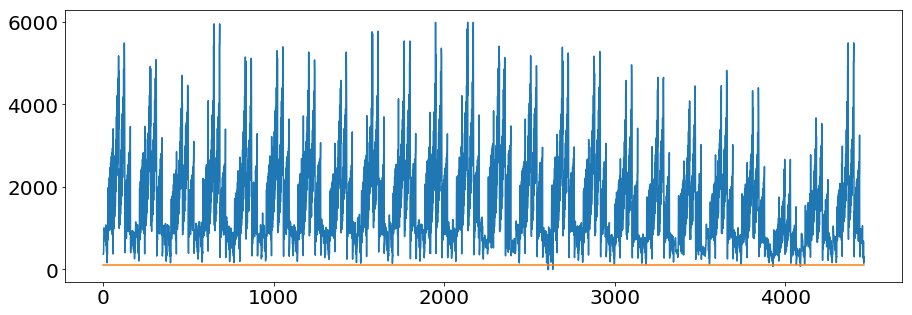

In [48]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(allN)
plt.plot([0,len(allChiSquareNDF)], [100,100])
#plt.ylim(0,250)
plt.show()

---

### Now lets take a look at the matrices we generated

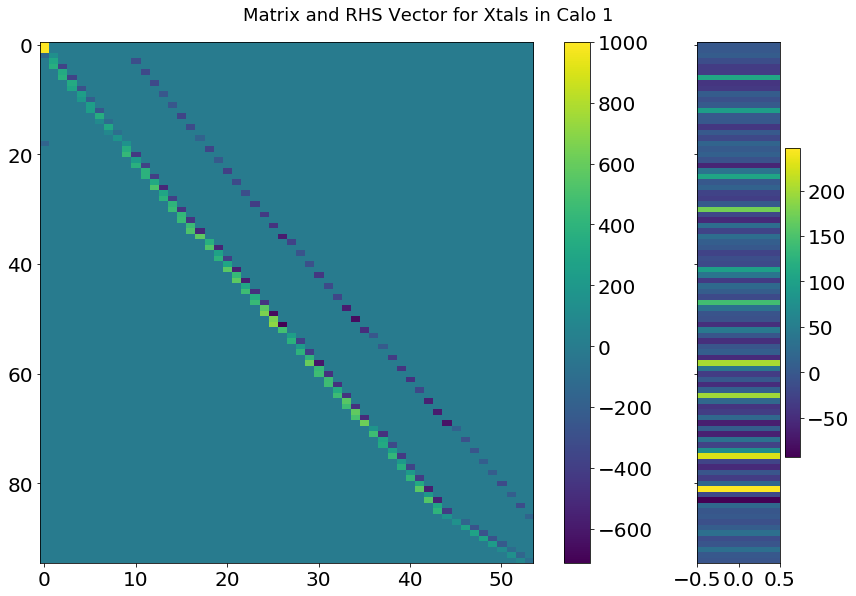

In [49]:
fig,ax = plt.subplots(1,2,figsize=(12,8), gridspec_kw={'width_ratios': [6, 1]}, sharey=True)
calo = 1
im = ax[0].imshow(caloMatrices[calo-1][1],
           #norm=matplotlib.colors.LogNorm(), 
           #vmin=-20, 
           vmax=1000,
           aspect='auto')
im2 = ax[1].imshow(caloMatrices[calo-1][2],
           #norm=matplotlib.colors.LogNorm(), 
           #vmin=-20, 
           #vmax=20,
           aspect='auto')
plt.colorbar(im, ax=ax[0])
plt.colorbar(im2, ax=ax[1])

plt.suptitle("Matrix and RHS Vector for Xtals in Calo "+str(calo), y=1.03, fontsize=18)
plt.tight_layout()

plt.show()

---

### Now lets solve for the timing constants for each calorimeter.

We do this suing singular value decomposition. This can be accomplished using a number of tools, but we will use numpy's lstsq (and scipy's lsq_linear as a cross check)

In [50]:
#now lets do the SVD using numpy
#    see: https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
caloSVD = []
from scipy import optimize

for calo, matrix, rhs in caloMatrices:
    if(False): #use least squares method from numpy
        timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix  = np.linalg.lstsq(matrix, rhs)
        timeConstants = timeConstants*-1 #invert calculated values to agree with conventions
        caloSVD.append( (calo, timeConstants, residuals, rankOfMatrix, singularValuesOfMatrix) )
    else: #use least squares from scipy
        rhsVec = np.ndarray.flatten(rhs)
        timeConstants = scipy.optimize.lsq_linear(matrix, rhsVec)
        caloSVD.append((calo, timeConstants['x']*-1, timeConstants))

In [51]:
print([x[0] for x in caloSVD])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


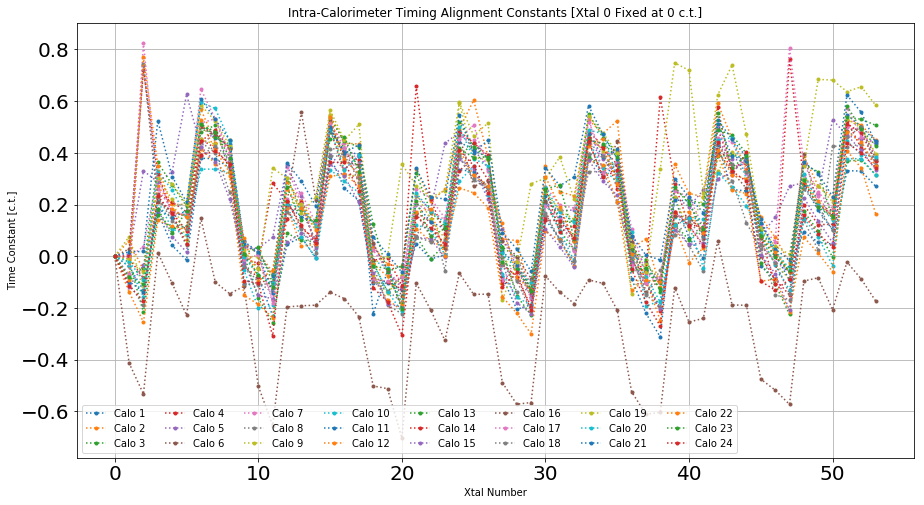

In [52]:
fig, ax = plt.subplots(figsize=(15,8))
#plt.ylim(-0.3,0.6)
for calo in range(24):
    plt.plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
plt.legend(ncol=8)
plt.title("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]")
plt.xlabel("Xtal Number")
plt.ylabel("Time Constant [c.t.]")
plt.grid()
plt.show()

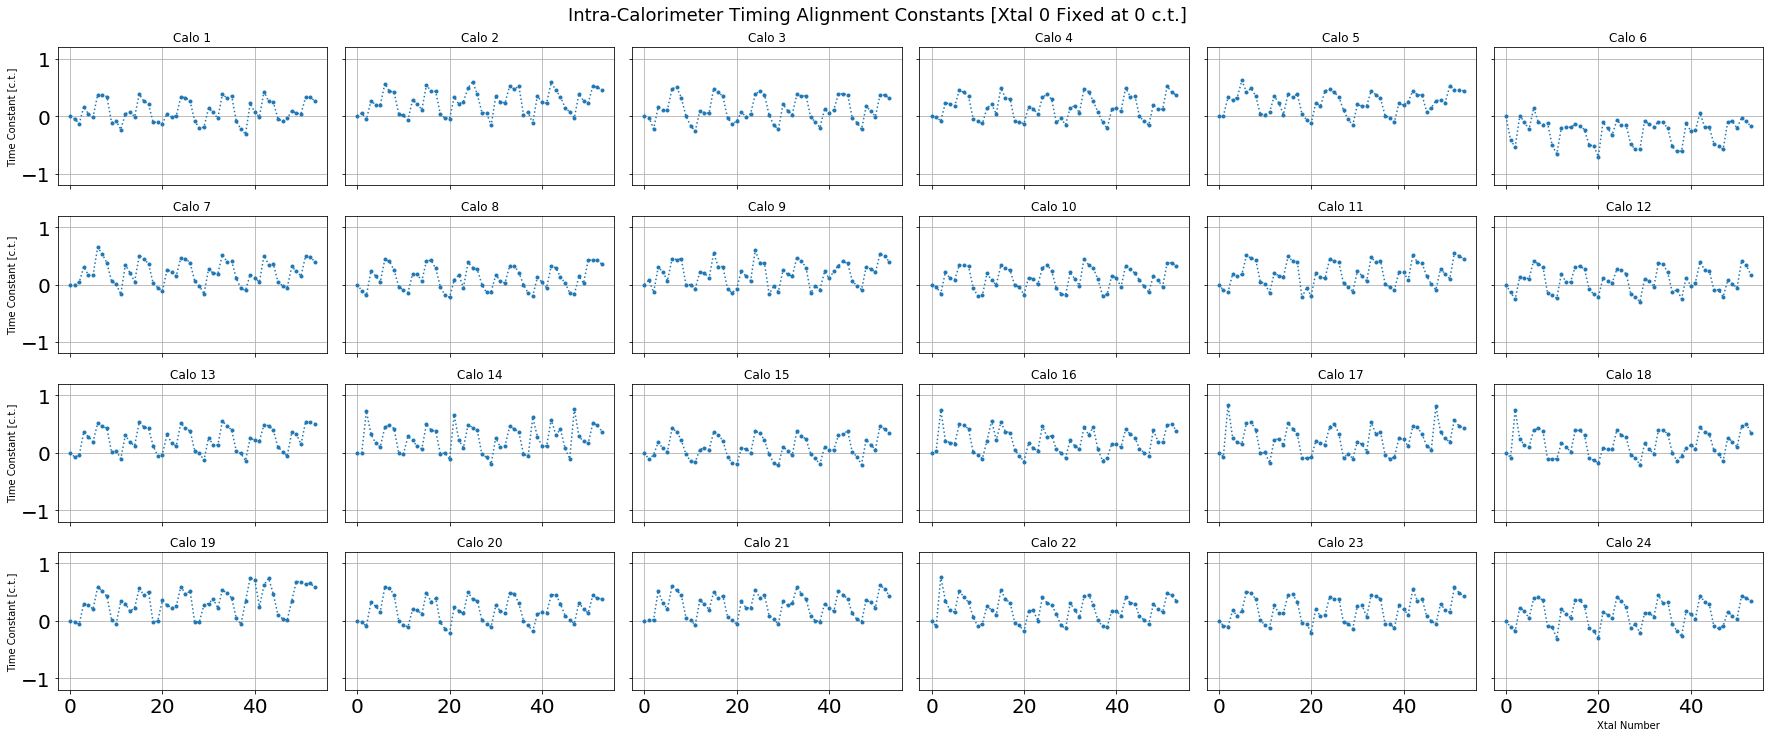

In [53]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Calo "+str(calo+1))
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
#plt.legend(ncol=8)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
plt.ylim(-1.2,1.2)
plt.show()

---

### Now lets compare with the values calculated by Jasons macro with the same parameters

For his constants, the value of xtal 0 is fixed

In [54]:
jasonConstants = [[np.nan for i in range(54)] for i in range(24)]

calo = -1
with open("./data/jasonConstants.txt") as file:
    for line in file:
        #print(line)
        if("Calo" in line):
            #print(line.split(" "))
            calo = int(line.split(" ")[3])
        if("xtal" in line):
            xtal = int(line.split(" ")[0].split('xtal')[1])
            constant = line.split(" ")[2].split("\n")[0]
            #print(calo, xtal, constant)
            jasonConstants[calo -1][xtal] = float(constant)
        if(jasonConstants[23][53] is not np.nan):
            break  

In [55]:
jasonConstantsF1 = [[0.0, -0.042, -0.134, 0.168, 0.039, -0.021, 0.372, 0.377, 0.336, -0.109, -0.083, -0.234, 0.045, 0.068, -0.01, 0.381, 0.26, 0.211, -0.11, -0.112, -0.134, 0.046, -0.015, 0.002, 0.33, 0.321, 0.257, -0.087, -0.212, -0.192, 0.136, 0.062, -0.042, 0.387, 0.306, 0.349, -0.098, -0.234, -0.318, 0.221, 0.065, -0.014, 0.425, 0.25, 0.249, -0.048, -0.098, -0.048, 0.093, 0.049, 0.04, 0.323, 0.323, 0.261], [0.0, 0.065, -0.049, 0.274, 0.206, 0.205, 0.573, 0.445, 0.426, 0.045, 0.02, -0.054, 0.291, 0.216, 0.121, 0.552, 0.438, 0.433, 0.042, -0.027, -0.038, 0.342, 0.215, 0.261, 0.496, 0.605, 0.385, 0.072, 0.065, -0.153, 0.355, 0.254, 0.236, 0.53, 0.475, 0.524, 0.035, 0.074, -0.113, 0.361, 0.247, 0.233, 0.593, 0.455, 0.337, 0.158, 0.082, -0.017, 0.392, 0.274, 0.233, 0.53, 0.507, 0.447], [0.0, -0.021, -0.222, 0.155, 0.109, 0.114, 0.482, 0.503, 0.317, 0.001, -0.164, -0.259, 0.087, 0.063, 0.056, 0.48, 0.417, 0.345, -0.027, -0.138, -0.086, 0.074, -0.012, 0.041, 0.386, 0.437, 0.374, 0.024, -0.154, -0.231, 0.208, 0.097, 0.026, 0.382, 0.349, 0.357, -0.019, -0.097, -0.201, 0.12, 0.062, 0.109, 0.383, 0.391, 0.375, -0.024, -0.108, -0.226, 0.17, 0.095, -0.007, 0.363, 0.366, 0.319], [0.0, -0.003, -0.08, 0.243, 0.206, 0.172, 0.451, 0.417, 0.348, -0.037, -0.075, -0.12, 0.145, 0.211, 0.04, 0.495, 0.324, 0.308, -0.082, -0.097, -0.126, 0.169, 0.134, 0.039, 0.33, 0.386, 0.298, -0.101, -0.038, -0.144, 0.15, 0.184, 0.062, 0.483, 0.429, 0.262, 0.074, -0.103, -0.212, 0.121, 0.155, 0.09, 0.493, 0.344, 0.359, -0.002, -0.091, -0.152, 0.198, 0.121, 0.123, 0.523, 0.418, 0.348], [-0.0, 0.009, 0.334, 0.292, 0.331, 0.635, 0.428, 0.494, 0.365, 0.042, 0.039, 0.072, 0.36, 0.238, 0.037, 0.396, 0.343, 0.395, 0.051, -0.055, -0.122, 0.24, 0.187, 0.444, 0.484, 0.422, 0.346, 0.109, -0.043, -0.151, 0.212, 0.184, 0.185, 0.454, 0.382, 0.318, 0.02, -0.016, -0.092, 0.237, 0.198, 0.262, 0.451, 0.384, 0.37, 0.076, 0.153, 0.275, 0.293, 0.245, 0.536, 0.47, 0.459, 0.451], [-0.0, -0.407, -0.526, 0.023, -0.098, -0.221, 0.15, -0.092, -0.137, -0.105, -0.495, -0.647, -0.188, -0.183, -0.183, -0.136, -0.157, -0.226, -0.492, -0.505, -0.694, -0.096, -0.198, -0.317, -0.06, -0.14, -0.139, -0.48, -0.563, -0.556, -0.068, -0.131, -0.175, -0.082, -0.098, -0.202, -0.513, -0.6, -0.593, -0.113, -0.245, -0.229, 0.068, -0.179, -0.183, -0.469, -0.511, -0.564, -0.088, -0.074, -0.194, -0.015, -0.076, -0.159], [0.0, -0.001, 0.038, 0.31, 0.165, 0.165, 0.65, 0.534, 0.381, 0.061, 0.01, -0.168, 0.345, 0.203, 0.051, 0.507, 0.44, 0.368, 0.028, -0.05, -0.113, 0.262, 0.224, 0.146, 0.463, 0.448, 0.377, 0.066, -0.018, -0.162, 0.272, 0.201, 0.187, 0.521, 0.392, 0.407, 0.111, -0.066, -0.099, 0.175, 0.121, 0.042, 0.505, 0.345, 0.363, 0.047, -0.02, -0.057, 0.314, 0.231, 0.145, 0.497, 0.482, 0.388], [0.0, -0.107, -0.19, 0.236, 0.155, 0.044, 0.442, 0.407, 0.251, -0.034, -0.098, -0.139, 0.188, 0.181, 0.065, 0.417, 0.421, 0.285, -0.033, -0.186, -0.219, 0.083, 0.169, -0.054, 0.384, 0.296, 0.265, -0.002, -0.137, -0.123, 0.168, 0.068, 0.03, 0.33, 0.329, 0.21, 0.001, -0.147, -0.198, 0.122, 0.046, -0.052, 0.332, 0.295, 0.129, 0.03, -0.144, -0.17, 0.141, 0.028, 0.433, 0.426, 0.439, 0.352], [-0.0, 0.073, -0.142, 0.291, 0.214, 0.057, 0.445, 0.431, 0.442, -0.006, -0.007, -0.08, 0.207, 0.197, 0.103, 0.54, 0.307, 0.306, -0.077, -0.149, -0.077, 0.234, 0.138, 0.061, 0.587, 0.376, 0.367, -0.167, -0.034, -0.133, 0.242, 0.171, 0.136, 0.463, 0.403, 0.286, -0.146, -0.034, -0.096, 0.22, 0.099, 0.223, 0.324, 0.396, 0.36, 0.057, -0.035, -0.097, 0.292, 0.267, 0.205, 0.527, 0.489, 0.39], [-0.0, -0.041, -0.159, 0.213, 0.106, 0.085, 0.333, 0.337, 0.325, -0.058, -0.201, -0.193, 0.192, 0.073, -0.008, 0.334, 0.289, 0.245, -0.018, -0.047, -0.18, 0.121, 0.102, 0.004, 0.288, 0.347, 0.235, -0.07, -0.159, -0.191, 0.211, 0.096, -0.02, 0.447, 0.34, 0.286, 0.091, -0.193, -0.17, 0.154, 0.117, -0.046, 0.32, 0.266, 0.194, 0.073, -0.034, -0.132, 0.147, 0.073, -0.039, 0.373, 0.373, 0.312], [-0.0, -0.098, -0.137, 0.185, 0.151, 0.178, 0.504, 0.458, 0.439, 0.053, 0.013, -0.14, 0.198, 0.155, 0.131, 0.489, 0.406, 0.395, -0.227, -0.056, -0.196, 0.203, 0.133, 0.105, 0.443, 0.408, 0.383, 0.019, -0.036, -0.128, 0.235, 0.152, 0.062, 0.473, 0.385, 0.415, 0.022, -0.047, -0.097, 0.218, 0.216, 0.077, 0.511, 0.389, 0.367, 0.149, 0.005, -0.094, 0.277, 0.178, 0.104, 0.547, 0.496, 0.452], [0.0, -0.134, -0.251, 0.143, 0.12, 0.111, 0.421, 0.359, 0.311, -0.139, -0.179, -0.233, 0.194, 0.043, 0.054, 0.316, 0.32, 0.279, -0.075, -0.16, -0.203, 0.112, 0.065, 0.04, 0.271, 0.251, 0.194, -0.149, -0.212, -0.293, 0.103, 0.068, -0.032, 0.376, 0.36, 0.217, -0.124, -0.083, -0.241, 0.126, -0.018, 0.039, 0.396, 0.26, 0.25, -0.091, -0.082, -0.209, 0.076, 0.018, -0.057, 0.414, 0.344, 0.17], [0.0, -0.078, -0.05, 0.362, 0.276, 0.19, 0.5, 0.461, 0.422, 0.006, 0.029, -0.107, 0.302, 0.18, 0.122, 0.53, 0.443, 0.42, 0.115, -0.063, -0.043, 0.317, 0.171, 0.114, 0.515, 0.421, 0.374, 0.034, -0.008, -0.137, 0.261, 0.132, 0.134, 0.549, 0.456, 0.397, 0.026, -0.016, -0.14, 0.253, 0.216, 0.201, 0.487, 0.466, 0.396, 0.095, 0.021, -0.068, 0.338, 0.317, 0.156, 0.535, 0.533, 0.509], [0.0, 0.006, 0.728, 0.323, 0.171, 0.103, 0.45, 0.489, 0.42, -0.007, -0.02, 0.288, 0.22, 0.112, 0.071, 0.498, 0.395, 0.375, -0.012, 0.001, -0.109, 0.664, 0.225, 0.09, 0.486, 0.439, 0.395, -0.026, -0.073, -0.19, 0.265, 0.098, 0.121, 0.459, 0.418, 0.358, -0.022, -0.058, 0.62, 0.282, 0.123, 0.117, 0.579, 0.315, 0.407, 0.076, -0.099, 0.77, 0.286, 0.195, 0.162, 0.516, 0.476, 0.363], [-0.0, -0.121, 0.0, 0.175, 0.071, 0.011, 0.414, 0.358, 0.209, -0.032, -0.154, -0.17, 0.051, 0.082, 0.048, 0.347, 0.3, 0.201, -0.072, -0.191, -0.201, 0.069, 0.061, -0.011, 0.366, 0.33, 0.212, -0.032, -0.183, -0.224, 0.1, 0.03, -0.051, 0.365, 0.281, 0.228, -0.026, -0.103, -0.206, 0.099, 0.04, 0.045, 0.295, 0.318, 0.371, -0.002, -0.073, -0.215, 0.221, 0.133, 0.046, 0.46, 0.401, 0.329], [-0.0, 0.031, 0.742, 0.21, 0.173, 0.149, 0.5, 0.465, 0.411, 0.006, -0.047, -0.105, 0.208, 0.554, 0.216, 0.524, 0.363, 0.345, 0.049, -0.055, -0.158, 0.163, 0.074, 0.027, 0.464, 0.266, 0.287, 0.06, -0.002, -0.084, 0.213, 0.118, 0.056, 0.437, 0.308, 0.439, 0.061, -0.137, -0.088, 0.157, 0.149, 0.094, 0.401, 0.323, 0.259, 0.077, 0.003, -0.054, 0.399, 0.193, 0.175, 0.479, 0.495, 0.381], [-0.0, -0.073, 0.826, 0.257, 0.178, 0.149, 0.506, 0.524, 0.389, -0.011, 0.004, -0.181, 0.22, 0.242, 0.122, 0.516, 0.414, 0.314, -0.094, -0.098, -0.083, 0.201, 0.171, 0.138, 0.449, 0.503, 0.326, -0.095, -0.02, -0.11, 0.191, 0.14, 0.019, 0.534, 0.317, 0.361, -0.036, -0.109, -0.082, 0.249, 0.226, 0.108, 0.451, 0.433, 0.316, 0.105, 0.05, 0.804, 0.351, 0.245, 0.176, 0.57, 0.455, 0.421], [-0.0, -0.091, 0.734, 0.226, 0.132, 0.098, 0.385, 0.418, 0.362, -0.114, -0.116, -0.113, 0.163, 0.099, 0.008, 0.378, 0.378, 0.3, -0.106, -0.139, -0.186, 0.066, 0.049, 0.055, 0.385, 0.295, 0.259, -0.043, -0.101, -0.218, 0.154, 0.051, -0.03, 0.387, 0.379, 0.32, -0.008, -0.154, -0.062, 0.076, 0.13, 0.063, 0.433, 0.346, 0.316, 0.037, -0.03, -0.152, 0.25, 0.178, 0.093, 0.454, 0.491, 0.34], [-0.0, -0.015, -0.049, 0.298, 0.288, 0.205, 0.587, 0.531, 0.425, 0.025, -0.052, 0.342, 0.303, 0.166, 0.231, 0.566, 0.45, 0.512, -0.028, 0.002, 0.357, 0.273, 0.228, 0.255, 0.596, 0.469, 0.517, -0.022, -0.022, 0.282, 0.301, 0.386, 0.223, 0.544, 0.48, 0.4, 0.043, -0.059, 0.337, 0.748, 0.719, 0.242, 0.624, 0.739, 0.472, 0.103, 0.038, 0.006, 0.343, 0.686, 0.674, 0.642, 0.65, 0.568], [-0.0, -0.02, -0.087, 0.327, 0.253, 0.149, 0.595, 0.572, 0.454, 0.004, -0.069, -0.101, 0.204, 0.189, 0.116, 0.491, 0.336, 0.393, -0.025, -0.132, -0.211, 0.246, 0.18, 0.131, 0.502, 0.379, 0.351, 0.014, -0.047, -0.1, 0.269, 0.171, 0.136, 0.489, 0.475, 0.305, 0.009, -0.074, -0.175, 0.12, 0.146, 0.146, 0.452, 0.461, 0.299, 0.101, 0.026, -0.049, 0.316, 0.202, 0.143, 0.448, 0.395, 0.38], [-0.0, 0.012, 0.01, 0.517, 0.302, 0.199, 0.601, 0.522, 0.442, 0.057, 0.013, -0.077, 0.361, 0.288, 0.189, 0.494, 0.398, 0.428, 0.076, 0.007, -0.063, 0.339, 0.225, 0.214, 0.538, 0.396, 0.444, 0.092, 0.029, -0.06, 0.34, 0.269, 0.302, 0.577, 0.466, 0.371, 0.078, 0.001, -0.02, 0.293, 0.225, 0.161, 0.524, 0.449, 0.377, 0.118, 0.021, -0.021, 0.355, 0.307, 0.22, 0.619, 0.555, 0.432], [0.0, -0.105, 0.756, 0.339, 0.172, 0.15, 0.51, 0.399, 0.314, 0.057, -0.11, -0.066, 0.248, 0.176, 0.092, 0.527, 0.364, 0.306, -0.047, -0.091, -0.195, 0.159, 0.175, -0.01, 0.401, 0.303, 0.263, 0.113, -0.095, -0.145, 0.296, 0.181, 0.046, 0.414, 0.443, 0.269, -0.004, -0.107, -0.114, 0.159, 0.159, 0.08, 0.4, 0.304, 0.29, 0.063, -0.001, -0.082, 0.275, 0.199, 0.137, 0.47, 0.425, 0.363], [0.0, -0.087, -0.115, 0.179, 0.081, 0.169, 0.507, 0.476, 0.371, 0.003, -0.077, -0.122, 0.265, 0.136, 0.132, 0.451, 0.461, 0.326, -0.041, -0.05, -0.205, 0.213, 0.075, 0.106, 0.416, 0.379, 0.383, -0.022, -0.051, -0.137, 0.259, 0.275, 0.069, 0.447, 0.433, 0.384, -0.054, -0.049, -0.132, 0.264, 0.198, 0.106, 0.554, 0.34, 0.391, 0.076, -0.006, -0.064, 0.291, 0.183, 0.145, 0.575, 0.489, 0.43], [0.0, -0.11, -0.171, 0.231, 0.167, 0.047, 0.39, 0.404, 0.35, -0.095, -0.102, -0.31, 0.214, 0.12, 0.05, 0.364, 0.36, 0.25, -0.118, -0.173, -0.303, 0.154, 0.11, 0.047, 0.411, 0.349, 0.24, -0.116, -0.06, -0.209, 0.14, 0.137, 0.07, 0.446, 0.303, 0.331, -0.047, -0.176, -0.269, 0.175, 0.118, 0.041, 0.441, 0.325, 0.288, -0.093, -0.129, -0.087, 0.162, 0.093, 0.038, 0.443, 0.397, 0.348]]
jasonConstantsF2 = [[-0.0, -0.042, -0.134, 0.168, 0.039, -0.02, 0.374, 0.379, 0.338, -0.109, -0.083, -0.234, 0.045, 0.069, -0.01, 0.382, 0.262, 0.213, -0.11, -0.112, -0.134, 0.046, -0.015, 0.002, 0.332, 0.323, 0.259, -0.087, -0.212, -0.192, 0.135, 0.061, -0.044, 0.0, 0.309, 0.352, -0.098, -0.235, -0.319, 0.22, 0.064, -0.015, 0.425, 0.252, 0.251, -0.049, -0.098, -0.048, 0.092, 0.049, 0.039, 0.323, 0.324, 0.262], [0.0, 0.065, -0.049, 0.274, 0.206, 0.205, 0.574, 0.446, 0.426, 0.045, 0.02, -0.054, 0.291, 0.216, 0.121, 0.552, 0.438, 0.434, 0.042, -0.027, -0.038, 0.342, 0.215, 0.262, 0.497, 0.606, 0.386, 0.072, 0.065, -0.154, 0.355, 0.253, 0.235, 0.0, 0.476, 0.525, 0.035, 0.074, -0.114, 0.361, 0.247, 0.233, 0.595, 0.457, 0.338, 0.158, 0.082, -0.017, 0.392, 0.274, 0.234, 0.531, 0.508, 0.448], [0.0, -0.021, -0.222, 0.155, 0.109, 0.115, 0.483, 0.505, 0.32, 0.001, -0.164, -0.259, 0.087, 0.063, 0.056, 0.481, 0.419, 0.348, -0.027, -0.138, -0.086, 0.074, -0.012, 0.042, 0.388, 0.439, 0.377, 0.024, -0.154, -0.231, 0.208, 0.096, 0.024, 0.0, 0.353, 0.36, -0.019, -0.097, -0.201, 0.12, 0.062, 0.11, 0.386, 0.394, 0.378, -0.024, -0.108, -0.226, 0.17, 0.095, -0.007, 0.365, 0.37, 0.323], [0.0, -0.003, -0.08, 0.243, 0.207, 0.173, 0.453, 0.42, 0.352, -0.037, -0.075, -0.12, 0.145, 0.211, 0.041, 0.498, 0.327, 0.312, -0.082, -0.097, -0.126, 0.169, 0.134, 0.039, 0.332, 0.391, 0.302, -0.102, -0.039, -0.145, 0.149, 0.183, 0.059, 0.0, 0.435, 0.267, 0.074, -0.104, -0.212, 0.121, 0.155, 0.09, 0.495, 0.349, 0.364, -0.002, -0.091, -0.153, 0.198, 0.121, 0.124, 0.526, 0.422, 0.353], [-0.0, 0.009, 0.334, 0.292, 0.331, 0.635, 0.429, 0.495, 0.367, 0.042, 0.039, 0.072, 0.36, 0.238, 0.037, 0.397, 0.344, 0.397, 0.051, -0.055, -0.122, 0.24, 0.187, 0.444, 0.484, 0.423, 0.347, 0.109, -0.043, -0.151, 0.212, 0.183, 0.184, 0.0, 0.385, 0.321, 0.02, -0.016, -0.092, 0.238, 0.198, 0.264, 0.455, 0.387, 0.372, 0.076, 0.153, 0.276, 0.294, 0.246, 0.538, 0.473, 0.462, 0.454], [-0.0, -0.406, -0.526, 0.023, -0.098, -0.221, 0.15, -0.093, -0.138, -0.105, -0.495, -0.647, -0.188, -0.183, -0.183, -0.136, -0.158, -0.227, -0.492, -0.505, -0.694, -0.096, -0.198, -0.317, -0.059, -0.141, -0.141, -0.48, -0.563, -0.557, -0.068, -0.131, -0.174, 0.0, -0.102, -0.205, -0.514, -0.6, -0.593, -0.113, -0.246, -0.231, 0.063, -0.184, -0.187, -0.469, -0.511, -0.564, -0.089, -0.076, -0.197, -0.019, -0.08, -0.163], [-0.0, -0.001, 0.038, 0.311, 0.165, 0.166, 0.651, 0.534, 0.381, 0.061, 0.01, -0.168, 0.345, 0.203, 0.051, 0.507, 0.441, 0.369, 0.027, -0.05, -0.113, 0.262, 0.224, 0.146, 0.464, 0.449, 0.378, 0.066, -0.018, -0.163, 0.272, 0.2, 0.187, 0.0, 0.393, 0.408, 0.111, -0.066, -0.1, 0.175, 0.121, 0.041, 0.504, 0.345, 0.363, 0.047, -0.02, -0.057, 0.314, 0.231, 0.145, 0.497, 0.482, 0.388], [-0.0, -0.107, -0.19, 0.236, 0.156, 0.045, 0.444, 0.409, 0.253, -0.034, -0.098, -0.139, 0.188, 0.181, 0.066, 0.419, 0.424, 0.288, -0.033, -0.186, -0.219, 0.083, 0.17, -0.054, 0.386, 0.299, 0.268, -0.002, -0.137, -0.123, 0.168, 0.067, 0.028, 0.0, 0.333, 0.213, 0.0, -0.148, -0.198, 0.121, 0.045, -0.053, 0.332, 0.297, 0.132, 0.03, -0.144, -0.17, 0.141, 0.027, 0.433, 0.426, 0.44, 0.354], [0.0, 0.073, -0.142, 0.29, 0.213, 0.056, 0.444, 0.429, 0.44, -0.006, -0.007, -0.08, 0.207, 0.196, 0.102, 0.538, 0.306, 0.304, -0.076, -0.148, -0.077, 0.234, 0.137, 0.06, 0.585, 0.374, 0.365, -0.166, -0.034, -0.133, 0.242, 0.172, 0.138, 0.0, 0.401, 0.284, -0.145, -0.034, -0.096, 0.221, 0.099, 0.224, 0.325, 0.395, 0.358, 0.058, -0.034, -0.096, 0.292, 0.268, 0.206, 0.527, 0.488, 0.388], [0.0, -0.041, -0.159, 0.213, 0.106, 0.084, 0.332, 0.337, 0.324, -0.058, -0.201, -0.193, 0.192, 0.073, -0.008, 0.334, 0.289, 0.245, -0.018, -0.047, -0.18, 0.121, 0.102, 0.004, 0.287, 0.346, 0.235, -0.07, -0.159, -0.191, 0.211, 0.096, -0.02, 0.0, 0.34, 0.285, 0.092, -0.192, -0.17, 0.154, 0.117, -0.046, 0.321, 0.266, 0.194, 0.073, -0.034, -0.131, 0.147, 0.073, -0.038, 0.374, 0.373, 0.312], [-0.0, -0.098, -0.137, 0.186, 0.151, 0.178, 0.505, 0.459, 0.44, 0.053, 0.013, -0.14, 0.198, 0.155, 0.132, 0.49, 0.407, 0.396, -0.228, -0.056, -0.196, 0.202, 0.133, 0.105, 0.445, 0.409, 0.383, 0.019, -0.036, -0.129, 0.234, 0.152, 0.061, 0.0, 0.386, 0.415, 0.021, -0.048, -0.098, 0.218, 0.215, 0.076, 0.51, 0.389, 0.367, 0.149, 0.005, -0.094, 0.277, 0.177, 0.103, 0.546, 0.496, 0.452], [-0.0, -0.134, -0.251, 0.143, 0.12, 0.112, 0.422, 0.36, 0.313, -0.139, -0.179, -0.233, 0.194, 0.043, 0.054, 0.317, 0.321, 0.281, -0.075, -0.16, -0.203, 0.112, 0.065, 0.04, 0.272, 0.253, 0.197, -0.15, -0.212, -0.293, 0.102, 0.068, -0.033, 0.0, 0.364, 0.22, -0.124, -0.083, -0.241, 0.126, -0.018, 0.039, 0.396, 0.263, 0.253, -0.091, -0.082, -0.209, 0.076, 0.018, -0.058, 0.414, 0.345, 0.172], [0.0, -0.078, -0.049, 0.363, 0.277, 0.191, 0.503, 0.465, 0.427, 0.006, 0.029, -0.107, 0.302, 0.181, 0.124, 0.533, 0.448, 0.426, 0.115, -0.063, -0.043, 0.317, 0.171, 0.115, 0.517, 0.426, 0.38, 0.034, -0.008, -0.138, 0.26, 0.131, 0.131, 0.0, 0.464, 0.405, 0.025, -0.017, -0.141, 0.253, 0.215, 0.201, 0.491, 0.472, 0.403, 0.094, 0.021, -0.068, 0.338, 0.318, 0.158, 0.539, 0.538, 0.515], [-0.0, 0.006, 0.728, 0.323, 0.171, 0.103, 0.451, 0.489, 0.42, -0.007, -0.02, 0.288, 0.22, 0.112, 0.071, 0.498, 0.395, 0.375, -0.012, 0.001, -0.109, 0.664, 0.225, 0.09, 0.486, 0.44, 0.395, -0.026, -0.073, -0.19, 0.265, 0.097, 0.121, 0.0, 0.419, 0.359, -0.022, -0.058, 0.62, 0.282, 0.123, 0.118, 0.58, 0.316, 0.407, 0.076, -0.099, 0.77, 0.286, 0.195, 0.162, 0.516, 0.476, 0.364], [-0.0, -0.121, 0.0, 0.175, 0.071, 0.011, 0.414, 0.358, 0.209, -0.032, -0.154, -0.17, 0.051, 0.082, 0.048, 0.347, 0.3, 0.201, -0.072, -0.191, -0.201, 0.069, 0.061, -0.011, 0.366, 0.33, 0.212, -0.032, -0.183, -0.224, 0.1, 0.03, -0.051, 0.365, 0.281, 0.228, -0.026, -0.103, -0.206, 0.099, 0.04, 0.045, 0.295, 0.318, 0.371, -0.002, -0.073, -0.215, 0.221, 0.133, 0.046, 0.46, 0.401, 0.329], [-0.0, 0.031, 0.742, 0.21, 0.173, 0.149, 0.501, 0.466, 0.412, 0.006, -0.047, -0.105, 0.208, 0.554, 0.217, 0.525, 0.364, 0.346, 0.049, -0.055, -0.158, 0.163, 0.074, 0.027, 0.466, 0.267, 0.288, 0.06, -0.002, -0.085, 0.213, 0.117, 0.055, 0.0, 0.308, 0.439, 0.06, -0.137, -0.088, 0.157, 0.148, 0.093, 0.398, 0.322, 0.259, 0.077, 0.003, -0.054, 0.399, 0.192, 0.174, 0.477, 0.493, 0.38], [-0.0, -0.073, 0.826, 0.257, 0.178, 0.148, 0.505, 0.523, 0.386, -0.011, 0.004, -0.181, 0.22, 0.242, 0.122, 0.515, 0.412, 0.311, -0.094, -0.098, -0.083, 0.201, 0.171, 0.138, 0.449, 0.5, 0.322, -0.095, -0.02, -0.11, 0.191, 0.14, 0.019, 0.0, 0.31, 0.356, -0.036, -0.109, -0.082, 0.249, 0.226, 0.108, 0.449, 0.429, 0.311, 0.105, 0.049, 0.804, 0.351, 0.244, 0.175, 0.568, 0.451, 0.417], [0.0, -0.091, 0.734, 0.226, 0.132, 0.098, 0.385, 0.418, 0.361, -0.114, -0.116, -0.113, 0.163, 0.098, 0.007, 0.378, 0.378, 0.299, -0.106, -0.139, -0.186, 0.066, 0.049, 0.055, 0.384, 0.294, 0.258, -0.043, -0.101, -0.218, 0.155, 0.051, -0.03, 0.0, 0.378, 0.319, -0.008, -0.154, -0.062, 0.076, 0.13, 0.063, 0.432, 0.345, 0.315, 0.037, -0.03, -0.152, 0.25, 0.178, 0.093, 0.453, 0.491, 0.339], [0.0, -0.015, -0.049, 0.298, 0.287, 0.205, 0.587, 0.532, 0.426, 0.025, -0.052, 0.342, 0.303, 0.166, 0.231, 0.565, 0.451, 0.514, -0.028, 0.002, 0.357, 0.273, 0.228, 0.254, 0.595, 0.471, 0.52, -0.022, -0.021, 0.283, 0.302, 0.386, 0.223, 0.0, 0.485, 0.405, 0.044, -0.059, 0.338, 0.749, 0.721, 0.245, 0.631, 0.744, 0.477, 0.103, 0.039, 0.007, 0.344, 0.688, 0.678, 0.647, 0.656, 0.573], [-0.0, -0.02, -0.087, 0.328, 0.253, 0.15, 0.597, 0.575, 0.457, 0.004, -0.069, -0.101, 0.204, 0.19, 0.117, 0.494, 0.339, 0.397, -0.025, -0.133, -0.211, 0.246, 0.18, 0.131, 0.505, 0.382, 0.355, 0.013, -0.047, -0.1, 0.269, 0.17, 0.134, 0.0, 0.479, 0.309, 0.009, -0.075, -0.176, 0.12, 0.145, 0.145, 0.45, 0.463, 0.302, 0.1, 0.026, -0.05, 0.315, 0.202, 0.142, 0.447, 0.397, 0.383], [-0.0, 0.012, 0.011, 0.517, 0.303, 0.199, 0.602, 0.525, 0.445, 0.057, 0.013, -0.077, 0.361, 0.288, 0.19, 0.495, 0.401, 0.432, 0.075, 0.007, -0.063, 0.339, 0.225, 0.214, 0.539, 0.4, 0.448, 0.091, 0.029, -0.06, 0.339, 0.268, 0.3, 0.0, 0.473, 0.377, 0.078, 0.001, -0.02, 0.293, 0.225, 0.162, 0.528, 0.455, 0.383, 0.117, 0.021, -0.021, 0.355, 0.308, 0.221, 0.622, 0.56, 0.438], [-0.0, -0.105, 0.756, 0.339, 0.173, 0.15, 0.511, 0.402, 0.318, 0.057, -0.11, -0.066, 0.248, 0.176, 0.092, 0.528, 0.367, 0.309, -0.047, -0.091, -0.195, 0.159, 0.175, -0.011, 0.401, 0.306, 0.268, 0.113, -0.095, -0.145, 0.296, 0.18, 0.045, 0.0, 0.451, 0.275, -0.004, -0.107, -0.113, 0.159, 0.16, 0.082, 0.405, 0.311, 0.296, 0.064, -0.001, -0.081, 0.275, 0.2, 0.139, 0.475, 0.431, 0.369], [-0.0, -0.087, -0.115, 0.179, 0.081, 0.169, 0.508, 0.477, 0.372, 0.003, -0.077, -0.122, 0.265, 0.136, 0.132, 0.451, 0.461, 0.326, -0.041, -0.05, -0.205, 0.213, 0.075, 0.106, 0.416, 0.379, 0.383, -0.022, -0.051, -0.137, 0.259, 0.275, 0.069, 0.0, 0.434, 0.385, -0.054, -0.049, -0.132, 0.264, 0.198, 0.106, 0.554, 0.341, 0.392, 0.076, -0.006, -0.064, 0.291, 0.183, 0.145, 0.575, 0.49, 0.431], [0.0, -0.11, -0.171, 0.231, 0.167, 0.047, 0.391, 0.406, 0.352, -0.095, -0.102, -0.31, 0.214, 0.12, 0.051, 0.365, 0.362, 0.252, -0.118, -0.173, -0.303, 0.154, 0.11, 0.047, 0.411, 0.351, 0.243, -0.116, -0.06, -0.209, 0.14, 0.137, 0.069, 0.0, 0.308, 0.335, -0.047, -0.176, -0.269, 0.175, 0.118, 0.042, 0.442, 0.329, 0.292, -0.093, -0.129, -0.087, 0.162, 0.093, 0.039, 0.445, 0.4, 0.352]]

In [56]:
aaronConstants = np.loadtxt("./data/aaronConstants.txt")
print(aaronConstants)

[[ 0.         -0.04074997 -0.13347036 ...  0.32934288  0.328431
   0.26451949]
 [ 0.         -0.04074996 -0.13347035 ...  0.32934316  0.32843104
   0.26451952]
 [ 0.         -0.04074996 -0.13347035 ...  0.32934288  0.32843102
   0.26451958]
 ...
 [ 0.         -0.10957298 -0.17089935 ...  0.44373328  0.39794827
   0.34915496]
 [ 0.         -0.10957301 -0.17089936 ...  0.44373315  0.39794816
   0.34915513]
 [ 0.         -0.10957296 -0.17089933 ...  0.4437333   0.39794828
   0.34915508]]


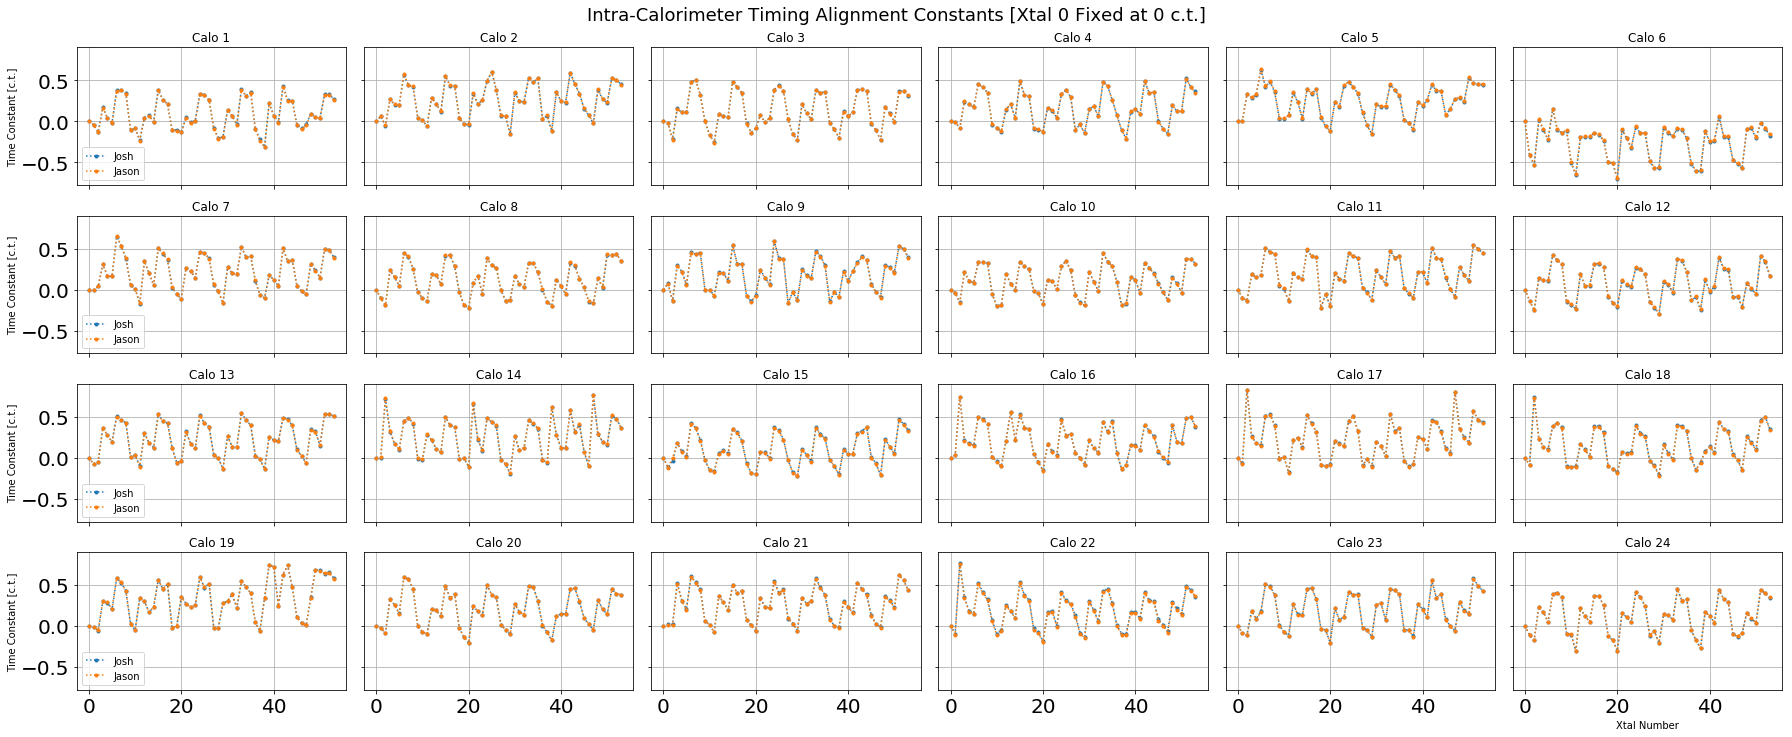

In [60]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
for calo in range(24):
    ax[calo].plot([i for i in range(54)], caloSVD[calo][1], ".:", label="Josh")
    ax[calo].plot([i for i in range(54)], jasonConstants[calo], ".:", label="Jason")
    #ax[calo].plot([i for i in range(54)], jasonConstantsF2[calo], ".:", label="Jason with Xtals Excluded")
    #ax[calo].plot([i for i in range(54)], aaronConstants[calo], ".:", label="Aaron")
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
        ax[calo].legend(loc=3)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel("Xtal Number")
plt.tight_layout()
#plt.ylim(-1.2,1.2)
plt.show()

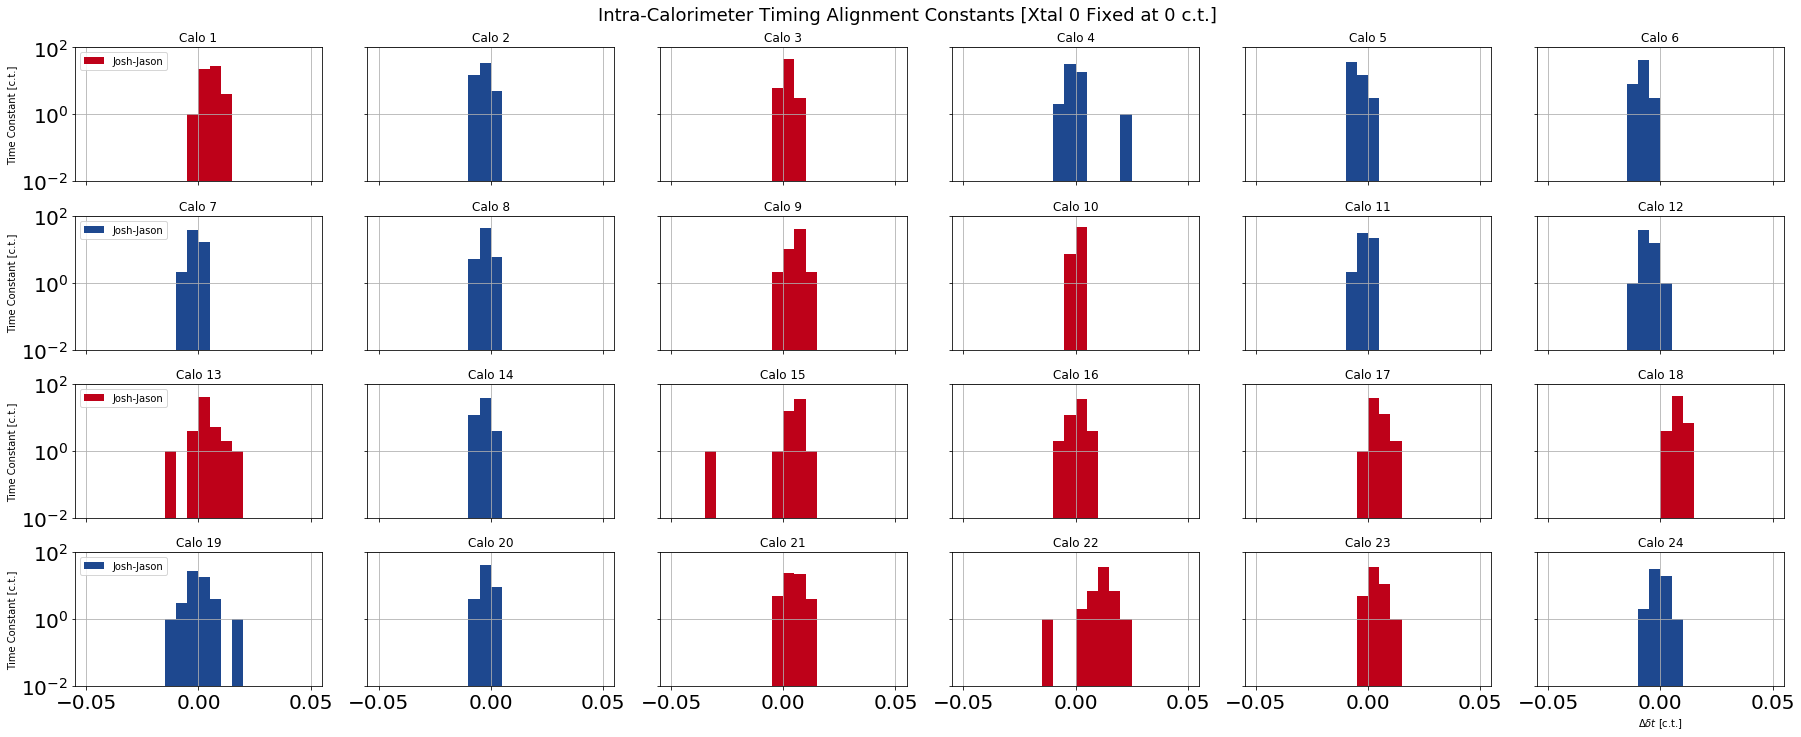

In [66]:
fig, axs = plt.subplots(4,6,figsize=(25,10), sharex=True, sharey=True)
#plt.ylim(-0.3,0.6)
ax = flatten2dArray(axs)
colors = ['xkcd:scarlet','xkcd:cobalt']
for calo in range(24):
    diff = [float(x)-y for (x,y) in zip(caloSVD[calo][1], jasonConstants[calo])]
    plotRange = (-0.05,0.05)
    plotBins = 20
    if(np.mean(diff)>0):
        ax[calo].hist(diff, bins=plotBins, label="Josh-Jason", range=plotRange, color=colors[0])
    else:
        ax[calo].hist(diff, bins=plotBins, label="Josh-Jason", range=plotRange, color=colors[1])
    #ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[int(np.floor(calo/4) % 2)])
    ax[calo].set_title("Calo "+str(calo+1))
    ax[calo].grid()
    ax[calo].set_yscale("log")
    if(calo % 6 == 0):
        ax[calo].set_ylabel("Time Constant [c.t.]")
        ax[calo].legend(loc=2)
plt.suptitle("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel(r"$\Delta \delta t$ [c.t.]")
plt.tight_layout()
plt.ylim(0.01,100)
#plt.xlim(-0.5,0.5)
plt.show()

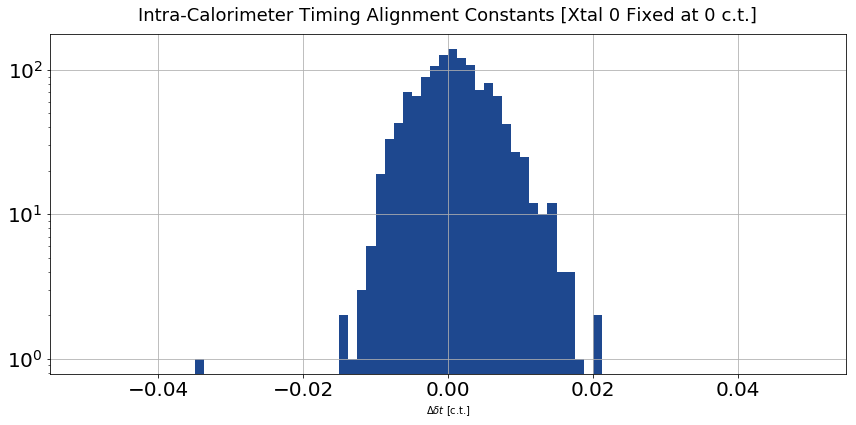

In [72]:
fig, ax = plt.subplots(figsize=(12,6), sharex=True, sharey=True)

allDiffs = []
for calo in range(24):
    diff = [float(x)-y for (x,y) in zip(caloSVD[calo][1], jasonConstants[calo])]
    allDiffs += diff
plotRange = (-0.05,0.05)
plotBins = 80
ax.hist(allDiffs, bins=plotBins, label="Josh-Jason", range=plotRange, color=colors[1])
#ax[calo].hist(diff, bins=80, label="Josh-Jason", range=(-0.5,0.5), color=colors[int(np.floor(calo/4) % 2)])
ax.grid()
ax.set_yscale("log")

plt.title("Intra-Calorimeter Timing Alignment Constants [Xtal "+str(xtalToFix)+" Fixed at 0 c.t.]",y=1.02, fontsize=18)
plt.xlabel(r"$\Delta \delta t$ [c.t.]")
plt.tight_layout()
#plt.ylim(0.01,100)
#plt.xlim(-0.5,0.5)
plt.show()

---

### Now lets generate the fcl file for the timing offsets